In [1]:
import gym
import random

In [2]:
class BJEnv(gym.Env):
    """
    Blackjack
    """
    
    class State:
        def __init__(self):
            # for the player I start with the sum rather than the cards to assure uniformity in the randomized start
            self.player_sum = random.randint(11, 21)
            # and so for the useful Ace
            self.player_useful_Ace = random.randint(0, 1) == 1 # boolean

            self.dealer_cards = [self._random_card(), self._random_card()]

        def _random_card(self):
            return random.randint(1, 10) # 1 - Ace, 2, .. 10

        def hits(self):
            new_card = self._random_card()
            self.player_sum += new_card # note since we start with 11 we cannot add another ACE.
            if self.player_sum > 21:
                if self.player_useful_Ace:
                    self.player_sum -= 10
                    self.player_useful_Ace = False
            return new_card
        
        def stick(self):                    
            return self._dealers_turn()
            
        def _dealers_turn(self):
            cur_sum = sum(self.dealer_cards)
            if cur_sum <= 11 and 1 in self.dealer_cards:
                cur_sum += 10
            while cur_sum < 17:
                self.dealer_cards.append(self._random_card())
                cur_sum = sum(self.dealer_cards)
                if cur_sum <= 11 and 1 in self.dealer_cards:
                    cur_sum += 10
            return cur_sum

        def render(self):
            if self.player_useful_Ace:
                print("Useful Ace")
            else:
                print("No useful Ace")
            print("Current sum: ", self.player_sum)
            print("Dealer showing: ",  self.card_to_image(self.dealer_cards[0]))
            
        def card_to_image(self, value):
            return "A" if value == 1 else value

                    
    def __init__(self):
        self.action_space = gym.spaces.Discrete(2) # 0 hits, 1 sticks
        
        obs_space = dict(
            player_sum = gym.spaces.Discrete(10), # x -> x + 11
            player_useful_Ace = gym.spaces.Discrete(2), # 0 no, 1 yes
            dealer_card = gym.spaces.Discrete(10) # 0 - Ace, x -> x + 1 (ex. 1 is 2, 9 is 10)
        )
        
        self.observation_space = gym.spaces.Dict(obs_space)
        self.reset()
    def render(self):
        self.state.render()
    def reset(self):
        self.state = BJEnv.State()
        return self._state_to_obs()
    def _state_to_obs(self):
        return {
            'player_sum' : self.state.player_sum - 11,
            'player_useful_Ace': 1 if self.state.player_useful_Ace else 0,
            'dealer_shown_card' : self.state.dealer_cards[0] - 1
        }
    def step(self, action):
        done = None
        reward = None
        info = {}
        if action == 1: # sticks
            dealer_sum = self.state.stick()
            if dealer_sum > 21:
                reward = 1 # dealer busted
            elif self.state.player_sum < dealer_sum:
                reward = -1 # lose
            elif self.state.player_sum == dealer_sum:
                reward = 0 # draw
            else:
                reward = 1 # win
            info['dealer sum'] = dealer_sum 
            done = True
        elif action == 0: # hits
            new_card = self.state.hits()
            done = False
            reward = 0
            info['new card'] = self.state.card_to_image(new_card)
            if self.state.player_sum > 21:
                reward = -1
                done = True
        else:
            assert False, f"unkown action {action}"
            
        return self._state_to_obs(), reward, done, info

In [3]:
env = BJEnv()

In [4]:
env.render()

No useful Ace
Current sum:  18
Dealer showing:  3


In [5]:
episodes = 5

for episode in range(episodes):
    print(f"Episode {episode}\n")
    obs = env.reset()
    while True:
        env.render()
        action = env.action_space.sample()
        obs, reward, done, info = env.step(action)
        print("action", action, "->", "reward", reward, "done", done, info, "\n")
        if done:
            break
    print("-" * 50)

Episode 0

Useful Ace
Current sum:  18
Dealer showing:  A
action 1 -> reward 1 done True {'dealer sum': 23} 

--------------------------------------------------
Episode 1

Useful Ace
Current sum:  17
Dealer showing:  8
action 1 -> reward -1 done True {'dealer sum': 18} 

--------------------------------------------------
Episode 2

No useful Ace
Current sum:  21
Dealer showing:  A
action 0 -> reward -1 done True {'new card': 5} 

--------------------------------------------------
Episode 3

No useful Ace
Current sum:  12
Dealer showing:  10
action 0 -> reward 0 done False {'new card': 4} 

No useful Ace
Current sum:  16
Dealer showing:  10
action 0 -> reward 0 done False {'new card': 2} 

No useful Ace
Current sum:  18
Dealer showing:  10
action 1 -> reward 1 done True {'dealer sum': 24} 

--------------------------------------------------
Episode 4

Useful Ace
Current sum:  16
Dealer showing:  10
action 1 -> reward -1 done True {'dealer sum': 18} 

------------------------------------

In [6]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

def MC_exploring_starts(episodes):
    # our initial, arbitrary, policy is to stick with 20 or 21 but otherwise to hit
    policy = dict()
    for player_sum in range(11): # 0 .. 10 -> 11 .. 21
        for dealer_showing in range(10):
            policy[0, player_sum, dealer_showing] = 0 if player_sum < 9 else 1 # sticks on 20 or 21
            policy[1, player_sum, dealer_showing] = 0 if player_sum < 9 else 1 # sticks on 20 or 21
    state_action_value = dict()
    returns = defaultdict(list)
    for i in range(episodes):
        start = env.reset()
        start_action = env.action_space.sample()
        # generating the episode that starts with our randomly chosen start and action
        s = start
        a = start_action
        current_episode = []
        while True:
            obs, reward, done, info = env.step(a)
            current_episode.append((s, a, reward, obs))
            if done:
                break
            s = obs                       
            a = policy[s['player_useful_Ace'], s['player_sum'], s['dealer_shown_card']]
        # update wrt the episode
        seen = set()
        for entry in current_episode:
            s, a, _, _ = entry
            s = (s['player_useful_Ace'], s['player_sum'], s['dealer_shown_card'])
            if (s, a) in seen:
                entry[1] = -1 # mark as don't update
            else:
                seen.add((s, a))
        gamma = 1 # discount factor
        g = 0
        for entry in reversed(current_episode):
            s, a, reward, _ = entry
            s = (s['player_useful_Ace'], s['player_sum'], s['dealer_shown_card'])
            g += reward
            if a > -1: # above we've used -1 to mark not to use for update
                returns[s, a].append(g)
                state_action_value[s, a] = np.mean(returns[s, a])
                policy[s] = np.argmax([state_action_value.get((s, action), 0) for action in [0, 1]])
    state_value = defaultdict(list)
    for k, v in state_action_value.items():
        s, a = k
        state_value[s].append(v)
    state_value = {
        k: np.max(v)
        for k, v in state_value.items() 
    }
    return policy, state_value

In [7]:
policy, state_value = MC_exploring_starts(1000)

In [8]:
def plot_policy(policy):
    m = np.zeros(shape=(11, 10), dtype=bool)
    for useful_ace in [0, 1]:
        print('useful_ace', 'Yes' if useful_ace == 1 else 'No')
        for player_sum in range(11):
            for dealer_showing in range(10):
                m[player_sum, dealer_showing] = policy[useful_ace, player_sum, dealer_showing] 
        fig = plt.figure()
        ax = fig.add_subplot(111)                
        msh = ax.matshow(m, interpolation="none")
        ax.set_ylim(-0.5, 10.5)
        ax.set_yticks(range(11))
        ax.set_xticks(range(10))
        ax.set_axisbelow(False)
        ax.set_yticklabels(list(map(lambda x: x + 11, range(11))))
        ax.set_ylabel('Player sum')
        ax.set_xticklabels(['A'] + list(map(str, range(2, 11))))
        ax.set_xlabel('Dealer showing')
        plt.gca().xaxis.tick_bottom()
        fig.colorbar(msh)
        plt.show()

useful_ace No


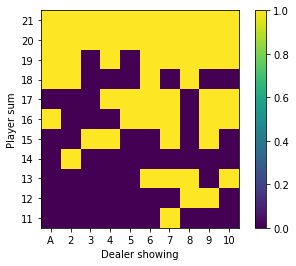

useful_ace Yes


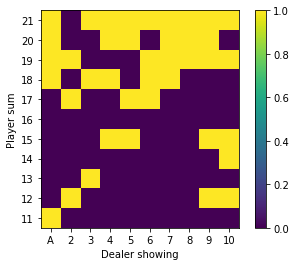

In [9]:
plot_policy(policy)

In [10]:
policy[(0,6,4)]

1

In [11]:
def plot_state_value(state_value):
    m = np.zeros(shape=(11, 10))
    for useful_ace in [0, 1]:
        print('useful_ace', 'Yes' if useful_ace == 1 else 'No')
        for player_sum in range(11):
            for dealer_showing in range(10):
                m[player_sum, dealer_showing] = state_value.get((useful_ace, player_sum, dealer_showing), None) 
        fig = plt.figure()
        ax = fig.add_subplot(111)                
        msh = ax.matshow(m, interpolation="none")
        ax.set_ylim(-0.5, 10.5)
        ax.set_yticks(range(11))
        ax.set_xticks(range(10))
        ax.set_axisbelow(False)
        # ax.set_yticklabels(map(lambda x: x + 11, range(10)))
        ax.set_yticklabels(list(map(lambda x: x + 11, range(11))))
        ax.set_ylabel('Player sum')        
        ax.set_xticklabels(['A'] + list(map(str, range(2, 11))))
        ax.set_xlabel('Dealer showing')        
        plt.gca().xaxis.tick_bottom()
        fig.colorbar(msh)
        plt.show()

useful_ace No


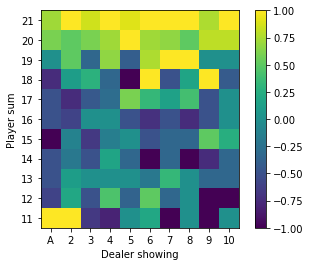

useful_ace Yes


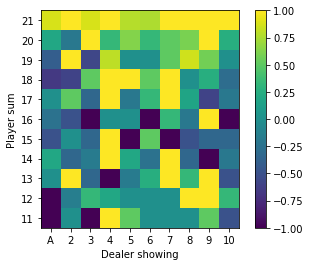

In [12]:
plot_state_value(state_value)